In [1]:
import os
import pathlib
import time
import zipfile
import tarfile

import imageio
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
import pickle
import time
from PIL import Image
import requests
import scipy.ndimage as ndimage
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, BatchNormalization
from tensorflow.keras.layers import Conv2D, Dense, Dropout, GaussianNoise
from tensorflow.keras.layers import Flatten, Input, MaxPooling2D, LeakyReLU
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import L1, L2
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize
import tqdm
from sklearn.model_selection import train_test_split
import pandas as pd

2024-05-03 21:48:28.526916: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-03 21:48:28.573127: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-03 21:48:28.573174: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-03 21:48:28.574361: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-03 21:48:28.581447: I tensorflow/core/platform/cpu_feature_guar

In [2]:
#!unzip -o ./tf_data.zip;


In [3]:
working_dir = pathlib.Path().absolute()
# Uncomment line below to debug if images don't show
#print(working_dir)
os.chdir(working_dir)


In [4]:
# RUN THIS CELL

# Enable/Disable Eager Execution
# Reference: https://www.tensorflow.org/guide/eager
# TensorFlow's eager execution is an imperative programming environment
# that evaluates operations immediately, without building graphs

print(f"tensorflow version {tf.__version__}")
print(f"Eager Execution Enabled: {tf.executing_eagerly()}\n")

devices = tf.config.get_visible_devices()
print(f"All Devices: \n{devices}\n")
print(f"Available GPUs: \n{tf.config.list_logical_devices('GPU')}\n")

# Better performance with the tf.data API
# Reference: https://www.tensorflow.org/guide/data_performance
AUTOTUNE = tf.data.AUTOTUNE

tf.random.set_seed(2266)

tensorflow version 2.15.0
Eager Execution Enabled: True

All Devices: 
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Available GPUs: 
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]



2024-05-03 21:48:31.833386: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-03 21:48:31.843336: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-03 21:48:31.846417: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [5]:
df = pd.read_csv('data/undersampled_top_10.csv')
X = []
y = []
df_efficient = df.set_index('catalogNumber')
df_efficient.head(5)

,Unnamed: 0,gbifID,references,basisOfRecord,sex,lifeStage,behavior,eventTime,month,continent,countryCode,verbatimElevation,decimalLatitude,decimalLongitude,mediaType,genus,species
catalogNumber,,,,,,,,,,,,,,,,,
XC361568,117,2243757996,https://data.biodiversitydata.nl/xeno-canto/ob...,HUMAN_OBSERVATION,NaN,NaN,flight call,6:07:00 PM,3.0,EUROPE,DE,260 m,48.9870,9.0108,Sound;StillImage;StillImage,Loxia,Loxia curvirostra
XC361676,122,2243757192,https://data.biodiversitydata.nl/xeno-canto/ob...,HUMAN_OBSERVATION,NaN,NaN,call,5:30:00 PM,3.0,EUROPE,GR,40 m,36.8217,21.9273,StillImage;StillImage;Sound,Sylvia,Sylvia atricapilla
XC361991,137,3909408313,https://data.biodiversitydata.nl/xeno-canto/ob...,HUMAN_OBSERVATION,NaN,NaN,call,10:00:00 AM,3.0,EUROPE,NL,0 m,52.3568,4.5675,StillImage;StillImage;Sound,Fringilla,Fringilla coelebs
XC362620,162,2243759376,https://data.biodiversitydata.nl/xeno-canto/ob...,HUMAN_OBSERVATION,NaN,NaN,"call, sweeoo call",2:27:00 PM,4.0,EUROPE,DE,300 m,49.0102,8.8949,Sound;StillImage;StillImage,Phylloscopus,Phylloscopus collybita
XC363724,205,2243761271,https://data.biodiversitydata.nl/xeno-canto/ob...,HUMAN_OBSERVATION,NaN,NaN,"call, imitation",7:30:00 AM,4.0,EUROPE,PL,160 m,53.1490,20.2591,Sound;StillImage;StillImage,Parus,Parus major


In [ ]:

test_dataset = tf.data.Dataset.load('tf_data/test_data')
train_dataset = tf.data.Dataset.load('tf_data/train_data')
val_dataset = tf.data.Dataset.load('tf_data/validation_data')

In [7]:
def normalize_image(img):
    return tf.cast(img, tf.float32)/255.

def preprocess(img, label):
    return normalize_image(img), label

train_dataset = train_dataset.map(preprocess).batch(32).prefetch(tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.map(preprocess).batch(32).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.map(preprocess).batch(32).prefetch(tf.data.experimental.AUTOTUNE)

In [8]:
Piczak_model_2 = Sequential([
    # First convolutional layer with 80 filters
    Conv2D(80, kernel_size=(125, 6), padding='same', input_shape=(128, 431, 1)),
    LeakyReLU(alpha=0.3),

    # Max pooling
    MaxPooling2D(pool_size=(4, 6)),

    # Second convolutional layer with 160 filters
    Conv2D(160, kernel_size=(1, 2), padding='same'),
    LeakyReLU(alpha=0.3),

    # Max pooling
    MaxPooling2D(pool_size=(1, 2)),

    # Continue the pattern...
    Conv2D(240, kernel_size=(1, 2), padding='same'),
    LeakyReLU(alpha=0.3),
    MaxPooling2D(pool_size=(1, 2)),

    Conv2D(320, kernel_size=(1, 2), padding='same'),
    LeakyReLU(alpha=0.3),
    MaxPooling2D(pool_size=(1, 2)),

    # Flatten the output of the conv layers to connect it with dense layers
    Flatten(),

    # Dropout layer
    Dropout(0.5),

    # Output layer with softmax activation
    Dense(10, activation='softmax', kernel_regularizer=L2(0.001))
])

Piczak_model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 431, 80)      60080     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128, 431, 80)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 71, 80)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 71, 160)       25760     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 71, 160)       0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 35, 160)       0         
 g2D)                                                   

This model has the same architecture as the baseline, but with the hypothesis that not letting the kernel move at all vertically (in the frequency direction) might be too restrictive; by letting the kernel move a little bit vertically, this would capture the intuition that a call that is only a few hertz away from another but with the same shape is likely the same bird. We still have the same depth as the baseline model. 

In [9]:
Piczak_model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
es = EarlyStopping(monitor="val_loss", patience=3)
history = Piczak_model_2.fit(train_dataset, epochs=20, validation_data = val_dataset, callbacks=[es])


Epoch 1/20


2024-05-03 21:48:34.613077: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906
2024-05-03 21:48:34.889305: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-03 21:48:36.313649: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-03 21:48:36.988232: I external/local_xla/xla/service/service.cc:168] XLA service 0x561804206a60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-03 21:48:36.988276: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-05-03 21:48:36.994387: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1714772917.101101    3142 device_compiler.h:186] Compiled

2303/2303 [==============================] - 585s 251ms/step - loss: 1.3626 - accuracy: 0.6197 - val_loss: 1.1513 - val_accuracy: 0.7120
Epoch 2/20
2303/2303 [==============================] - 577s 251ms/step - loss: 1.1077 - accuracy: 0.7418 - val_loss: 1.0591 - val_accuracy: 0.7612
Epoch 3/20
2303/2303 [==============================] - 578s 251ms/step - loss: 1.0475 - accuracy: 0.7691 - val_loss: 0.9635 - val_accuracy: 0.8008
Epoch 4/20
2303/2303 [==============================] - 577s 250ms/step - loss: 1.0157 - accuracy: 0.7858 - val_loss: 0.9927 - val_accuracy: 0.8019
Epoch 5/20
2303/2303 [==============================] - 576s 250ms/step - loss: 1.0048 - accuracy: 0.7960 - val_loss: 0.9931 - val_accuracy: 0.8102
Epoch 6/20
2303/2303 [==============================] - 575s 250ms/step - loss: 0.9928 - accuracy: 0.8037 - val_loss: 1.0144 - val_accuracy: 0.8000


In [10]:
Piczak_model_2.save_weights('smaller_kernel.h5')
with open('smaller_kernel', 'wb') as file_pi:
    pickle.dump(history, file_pi)

In [11]:
def plot_hist(model, title=None):
    fig, axs = plt.subplots(1,2, figsize=(12,5))
    axs[0].plot(model.history['loss'], label='train')
    axs[0].plot(model.history['val_loss'], label='val')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('CE Loss')
    axs[0].set_title('Loss')
    axs[0].legend()
    axs[1].plot(model.history['accuracy'], label='train')
    axs[1].plot(model.history['val_accuracy'], label='val')
    axs[1].set_title('Accuracy')
    axs[1].legend()
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('ACC')
    plt.suptitle(title)

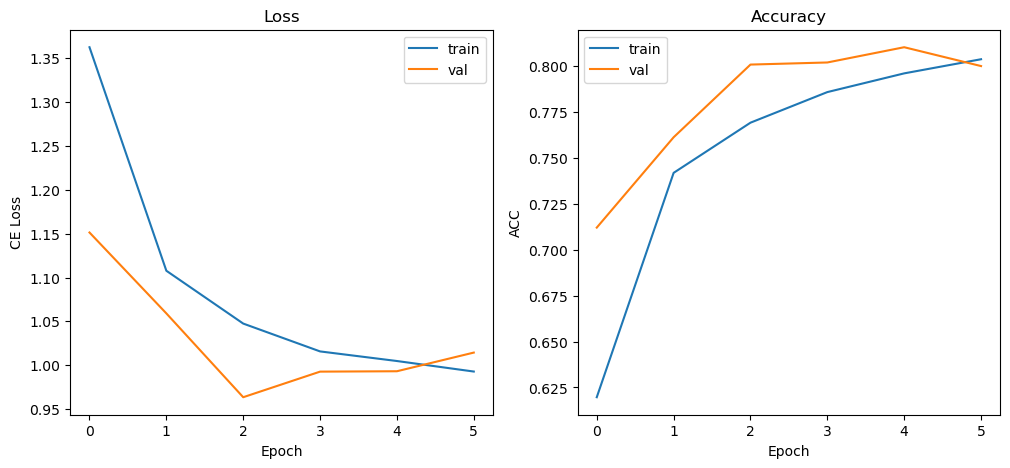

In [12]:
plot_hist(history)

We can see that we overfit at epoch 3, so training completes very quickly. The validation accuracy hovers around 0.8, similarly to the baseline.

In [13]:
test_loss, test_accuracy = Piczak_model_2.evaluate(test_dataset, verbose=1)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

720/720 [==============================] - 88s 122ms/step - loss: 1.0112 - accuracy: 0.8038
Test Loss: 1.0111855268478394
Test Accuracy: 0.8037870526313782


Our model performs pretty much as well as the baseline model, but not significantly better. Thus, it seems like our original baseline model already allows for some variation within the frequency domain, or the variation in the frequency domain is typically negligible/subsumed by learning other features. 